AB-test with python ： Udacity course final project

Name：Zhiyan Yang

# 1. 背景以及目的

Udacity是一家提供免费的在线学习课程的教育平台，用户只需要找到自己想上的课程，点击网页按钮“Free Trial（免费试用）”即可进入课程进行学习，当课程结束后，网站会统计用户的完成率，以此为依据给课程以及授课老师进行打分。

在本次实验进行期间，Udacity 课程概览页面上提供两种选项：“开始免费试用（start free trial）” 和 “访问课程资料（access course materials）”。

如果学生点击“开始免费试用”，系统将要求他们输入信用卡信息，并随后将其注册到该课程的付费版本的免费试用中。试用期为14天，若学生未提前取消，则试用期结束后将自动扣费。

如果学生点击“访问课程资料”，他们将可以免费观看课程视频并完成测验，但不会获得导师支持或认证证书，也无法提交最终项目获取反馈。

在本次实验中，Udacity 测试了一项更改：当学生点击“开始免费试用”时，系统会询问他们每周能投入多少时间学习该课程。

如果学生表示每周可投入 5 小时或以上，他们将照常进入结账流程；而如果他们表示每周投入时间 少于 5 小时，系统则会弹出一条信息，说明 Udacity 课程通常需要更高的时间投入才能顺利完成，并建议学生可以选择免费访问课程资料。

此时，学生仍可选择继续注册免费试用，或改为免费访问课程资料。


# 2. 选择变量

## 2.1 control variable

是指原则上，在实验中不能改变的变量。目的是为了避免这些变量影响实验结果

比如说：如果我们进行实验的一组用户是老用户，他们已经熟知Udacity的流程并且有历史记录他们在Udacity上完成了很多课程了\
            而另外一组用户的网站的新用户，他们不知道Udacity如何用作，课程有哪些类型，也许他们只是从其他途径知道了Udacity而登录网页了解一下罢了

一般在业务进行中，数据分析师会根据数据和业务种类，先列举很多他们认为相关的control variables，然后再进行筛选

在Udacity这个案例中，我们选择的control variables如下：
1. 访客数（去重）       Pageviews
2. Free Trail的点击量  Clicks
3. 点击率             CTP = Clicks/Pageviews

为什么要设计这些为control variables？\
答：我们希望在相同的用户点击下，查看不同方案中，用户的课程完成度。比如说A组和B组都有3000个用户浏览了网站并且都有500个用户点击了Free Trail按钮进行课程的免费学习，我们想知道在不同的方案下（有弹窗和无弹窗），课程的转化率是否会有显著的提升。

## 2.2 evaluation metrics

和control variables不同的是，control variables是我们不希望在实验中进行变化的指标，而evaluation metrics是我们希望在实验中有所变化的指标

在这个案例中，我们选择了2个指标：
1. 课程注册转化率 = 课程注册用户数量/Free Trail 点击数量
2. 全流程转化率/付费转化率 = 课程付费用户数量/ Free Trial 点击数量

## 2.3 baseline设置

在开始实验之前，我们需要知道这些指标在策略上线之前的平时表现如何，即baseline values，基线值。这些数据应该是从日常数据中聚合得到的(日均)

In [2]:
baseline = {'Cookies':40000,
           'Clicks':3200,
           'Enrollments':660,
           'CTP':0.08,
           'GConversion':0.20625,
           'NConversion':0.109313}

Cookies: 网页访客数（去重）\
clicks：Tree Trial的点击量\
enrollment：注册数\
CTP：Free Trial的点击率\
GConversion：注册转化率（点击Free Trial按钮后最后成功注册的概率）\
NConversion：付款转化率（点击Free Trial后付款的概率）


# 3. 估计参数的标准差

这一步的目的是为后续计算实验的样本量 以及 显著性检验的标准误差 做准备

## 3.1 Scaling & 计算标准差的公式

估计标准差(Standard Deviation)是后续计算实验样本量和置信区间的前提。同时，如果指标变化越大，获得置信结果就越难。

缩放数据：Cookies为5000个样本

In [3]:
baseline['Cookies'] = 5000
baseline['Clicks'] = baseline['Clicks'] * (5000/40000)
baseline['Enrollments'] = baseline['Enrollments'] * (5000/40000)
baseline

{'Cookies': 5000,
 'Clicks': 400.0,
 'Enrollments': 82.5,
 'CTP': 0.08,
 'GConversion': 0.20625,
 'NConversion': 0.109313}

接下去我们就要估计数据标准差

首先GConversion：课程注册转化率 = 课程注册用户/Free Trail点击数量 \
用户在点击按钮后，要么注册课程，要么退出不注册课程，所以这里X（注册用户数）服从一个二项分布：X~Bin（n,p）\
我们假设用户点击后注册课程的概率为p，那么样本的 p_hat = X/n\
那么GConversion的总体方差为 Var(GConversion) = Var(p) = Var(X/n) = 1/n^2 * Var(X) = p(1-p)/n\
我手写一个过程\
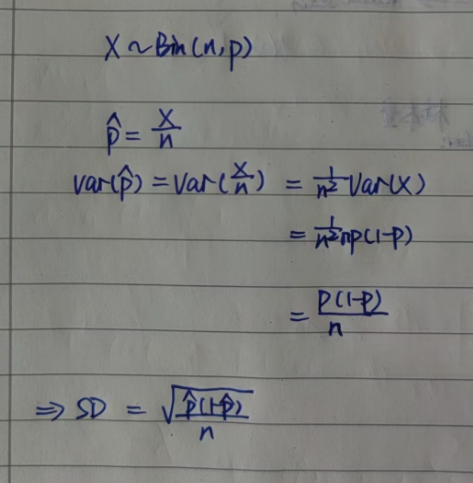





这里我们将Cookies作为分流单元unit of diversion：就是按照CookieID进行分组\
这里的分析单元unit of analysis 是点击Free Trial的Cookies数：只有点击行为的Cookies才会被纳入计算\
简单说：分子是注册数，分母是点击数，他们都是基于Cookies的

## 3.2 D_min

minimum detectable effect\
Dmin = 实验需要检测的最小效应量 = treatment组对control组，指标变化幅度的最小阈值\
只有当这个变化达到或者超过Dmin时，才被认为具有业务意义\
换句话说，就是问：当某个指标需要提升或者减少多少时，这个实验才值得上线？\
这个案例中给出的GC的Dmin = 0.01 ，即，当GC至少要提升或者减少1%，实验才值得上线

## 3.3 计算GC标准差

首先我们要获取p和n的值\
本案例中p就是GC的值（观测到的数据）\
n就是点击量

在计算之前，我们先要导入python的包

In [4]:
# 先是三剑客,无论用不用,反正先导入
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 然后是我们案例中需要用到的包
import math
from scipy.stats import norm

In [5]:
GC = {}
GC['dmin'] = 0.01
GC['p'] = baseline['GConversion'] # 如果没有给出,我们也可以计算, p = enrollment / clicks
GC['n'] = baseline['Clicks']
GC['sd'] = np.sqrt(GC['p'] * (1 - GC['p']) / GC['n'])
print(GC['sd'])

0.020230604137049392


## 3.4 计算NC标准差

NConversion = 付款转化率 = 付款的用户数量/点击量\
那么此时的p值就是NC的值\
同样得，付款用户的数量也是符合二项分布\
本案例中NC的Dmin为0.0075

In [6]:
NC = {}
NC['dmin'] = 0.0075
NC['p'] = baseline['NConversion']
NC['n'] = baseline['Clicks']
NC['sd'] = np.sqrt(NC['p'] * (1 - NC['p'])/NC['n'])
print(NC['sd'])

0.015601575884425905


In [7]:
print('注册转化率GC的样本标准差为：{}'.format(GC['sd']))
print('付费转化率NC的样本标准差为: {}'.format(NC['sd']))

注册转化率GC的样本标准差为：0.020230604137049392
付费转化率NC的样本标准差为: 0.015601575884425905


# 4. 估计实验样本量

上面我们已经估计了样本的标准差了，有了样本标准差，就可以估计实验的样本量了\
那么估计样本量，我们还需要2个参数：α = 0.05 (significance level) 和 β = 0.2(power) \
那么我们的样本量n是什么呢？ \
答：是网页访客数(浏览量，也就是去重的Cookies)


## 4.1 Aplha(α) & Beta(β)

1. alpha： α = significance level  = Probability of Type I error \
   H0 为真，但是我们拒绝了H0\
   在本案例中，H0就是新策略不会带来更好的收益，而我们却认为它可以带来更好的收益
   
2. beta: β = Probability of Type II error\
   H1 为真，H0为假，但是我们接受了H0\
   power = 1 - β = 有多大的把握能发现真正的效应


一般情况下，Alpha 减小，Beta的值变大
   
   

## 4.2 计算样本量

AB-test中计算样本量的前提：
1. 显著性水平 α
2. β的值
3. 两组样本均值的差异

### 4.2.1 双样本假设检验

在AB-test中，假设检验几乎总是双样本的假设检验\
换句话说，就是比较2个不同组在某个指标上的表现是否有显著差异\
在这个案例中：\
H0：p_control - p_treatment = 0  \
vs\
H1：p_control - p_treatment = d

我们想知道，为了在显著性水平alpha，功效检验1-beta下，检测到2组比较差为d时，每组需要多少的样本量

2组样本互相独立，那么Var(p1-p2) = Var(p1) + Var(p2)

那么就要算出H0下的p1和p2的方差，以及H1下p1和p2的方差

关键思想：要使检测到效应d的概率 >= 1-beta，即检验功效达到标准

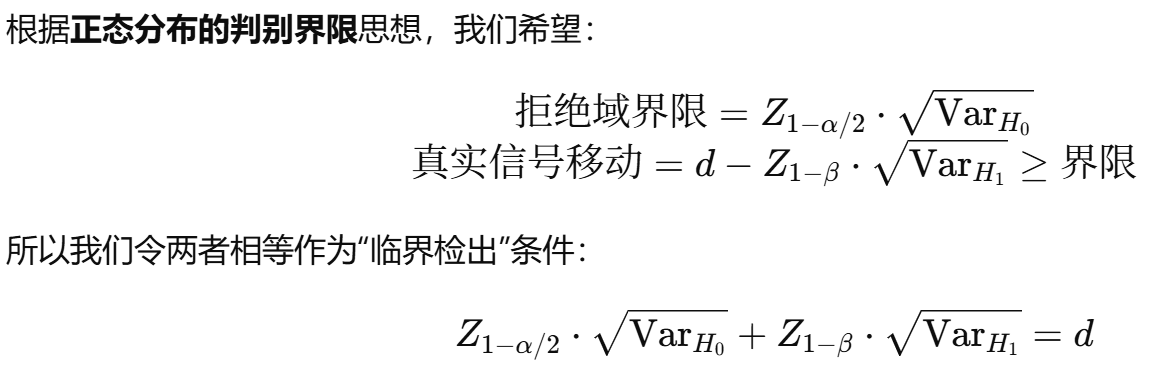

因为control组和treatment组的样本都是完全随机抽取的，并且每一次浏览和点击都是独立的\
所以我们的案例是一个独立的双样本的假设检验\
对于比较2个独立样本的差异，我们使用Z检验统计量：\
Z = ((p_control - p_treatment) - 0)/SE\
SE是标准误，在H0和H1下的计算是不同的

### 4.2.2 H0下的方差

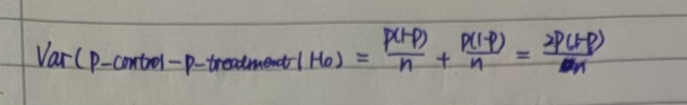

### 4.2.3 H1下的方差

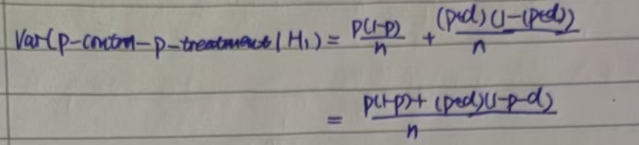

### 4.2.4 计算样本量n

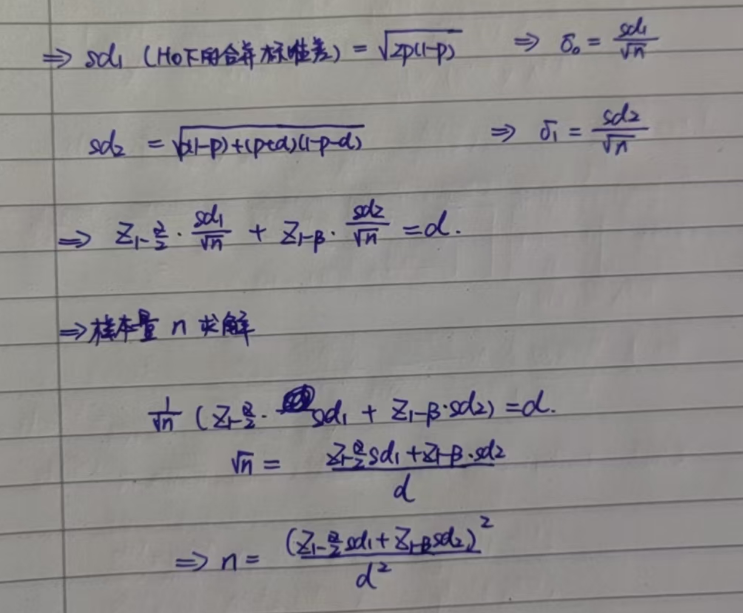

## 4.3 代码实现与结果计算

计算sd1和sd2

In [8]:
def get_sds(p,d):
    sd1 = np.sqrt( 2*p*(1-p) )
    sd2 = np.sqrt( p*(1-p) +(p+d)*(1-p-d) )
    sds = [sd1,sd2]
    return sds

计算 Z-score

In [9]:
def get_z_score(alpha):
    return norm.ppf(alpha)

计算样本量

In [10]:
def get_sample_size(alpha,beta,sds,d):
    part1 = get_z_score(1-alpha/2) * sds[0]
    part2 = get_z_score(1-beta) * sds[1]
    up = np.power((part1+part2),2)
    down = np.power(d,2)
    n = up/down
    return n

In [11]:
print("注册转化率的d为：{}".format(GC['dmin']))
print("付费转化率的d为：{}".format(NC['dmin']))

注册转化率的d为：0.01
付费转化率的d为：0.0075


In [12]:
p = GC['p']
d = GC['dmin']
sds = get_sds(p,d)
GC_samples = get_sample_size(alpha = 0.05,beta=0.2,sds = sds,d = GC['dmin'])
GC_sampels = round(GC_samples)
GC_sampels

25835

此时我们计算出的25835是一个组中点击Tree Trail按钮的点击量\
记得我们的GC = enrollment/Clicks\
而我们需要的样本单元是Cookies\
而Cookies = Clicks/CTP(点击率)\
所以我们的总样本就是 28353(Clicks)/0.08(CTP)*2(groups)

In [13]:
total_samples = GC_sampels/baseline['CTP']*2
total_samples

645875.0

综上所述：当我们要比较GC(课程注册转化率)在2组之间是否有明显差异时，所需的实验样本量为645875(Cookies，即浏览量)

那么下面我们要比较的是NC(付费转化率)，计算一下样本量n

In [14]:
p_nc = NC['p']
d_nc = NC['dmin']
sds_NC = get_sds(p_nc,d_nc)
NC_samples = get_sample_size(alpha = 0.05,beta=0.2,sds=sds_NC,d = NC['dmin'])
NC_samples = round(NC_samples)
totoal_samples = NC_samples/baseline['CTP'] *2
totoal_samples

685325.0

综上：当我们需要比较NC(课程付费转化率)在2组之间是否有明显差异的时，所需的实验样本量为685325(Cookies,即浏览量)

当我们根据不同的比较标准(GC,NC)计算得到不同的实验样本量后，最后选择大的那个数来作为我们最终的实验样本量

# 5. 计算时间周期period

当我们已经确定了上述的各种条件和数据后\
我们想知道采集样本需要多少时间？\
或者说我们想在哪一个时间段内采集样本，才可以让我的数据充满随机性而不影响实验结果

在这个案例中，网页每天的浏览量(user_view) = 40000\
我们计划每天采集浏览量中的80%，即40000*0.8=32000作为我们的样本使用\
那么我们需要采集数据的周期，即实验周期为685325/32000 = 21天  （at least！！！）\
我们的实验数据收集的是37天的数据,平均每天收集的浏览量为18473左右

终于，到目前为止，我们已经获得了可以进行AB-testing的一切\
下面开始真正的关于AB-test的部分

# 6. AB-test

## 6.1 加载收集的数据

In [15]:
control_data = pd.read_csv('control_data.csv')
treatment_data = pd.read_csv('experiment_data.csv')

In [16]:
control_data.info()
print(control_data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         37 non-null     object 
 1   Pageviews    37 non-null     int64  
 2   Clicks       37 non-null     int64  
 3   Enrollments  23 non-null     float64
 4   Payments     23 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 1.6+ KB
(37, 5)


In [17]:
treatment_data.info()
print(treatment_data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         37 non-null     object 
 1   Pageviews    37 non-null     int64  
 2   Clicks       37 non-null     int64  
 3   Enrollments  23 non-null     float64
 4   Payments     23 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 1.6+ KB
(37, 5)


控制组和实验组都是37行，5列的数据集

In [18]:
control_data.head()

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7723,687,134.0,70.0
1,"Sun, Oct 12",9102,779,147.0,70.0
2,"Mon, Oct 13",10511,909,167.0,95.0
3,"Tue, Oct 14",9871,836,156.0,105.0
4,"Wed, Oct 15",10014,837,163.0,64.0


In [60]:
control_data['Pageviews'].sum() +treatment_data['Pageviews'].sum()

690203

## 6.2 合理性检查

合理性检查： Sanity Checks，也可以称作是健全性检查\
其目的是检查Control variables在2组之间是否有显著的差异\
我们需要得到的结果是：没有显著的差异，即这些我们希望不变的参数是不会影响我们最终实验的结果的\
确保实验分组正确，样本量合理，数据采集没有异常，没有系统性偏差

在本案例中，我们需要检查的是2.1中的Control variables
1. 页面访客数(UV) ：number of Cookies in Course overview page
2. Free Trail的点击量 ： number of Clicks on Free Trail Button
3. 点击率CTP ： Free Trail button clicks-through-probability

如果上面3个control variables在实验的2组之间具有显著差异，那么我们实验的最终结果是不可靠的\
如果出现显著差异的情况，那么则需要暂停实验并诊断问题根源\
解决办法我会单独写一个markdown，找一个案例来展示

### 6.2.1 对浏览量UV的合理性检查

In [19]:
totoal_view = control_data['Pageviews'].sum() + treatment_data['Pageviews'].sum()
print(control_data['Pageviews'].sum())
print(treatment_data['Pageviews'].sum())
print(totoal_view)

345543
344660
690203


我们可以看到，对照组control和实验组treatment的样本量近似相同，并且总样本量也大于我们设计的样本量683525\
那么接下午我们需要通过假设检验方法，看看cookies的数量是否有显著差异

我们希望的是样本被分配到2个组的概率是相同的：50%，并且是随机的\
也就是说，对于一个随机的Cookie，它既可能被分到control组，也可能被分到treatment组，分配的概率是相同的，并且所有的Cookies都是相互独立的\
那么我们的Cookies被分配到control组的数量X应该是符合二项分布的  X ~ Bin(n,p)\
那么p = X/n，而当n很大时，根据中心极限定理,X近似符合正态分布，X ~ N(p,p(n-p)/n)\
下面我手推了一下公式

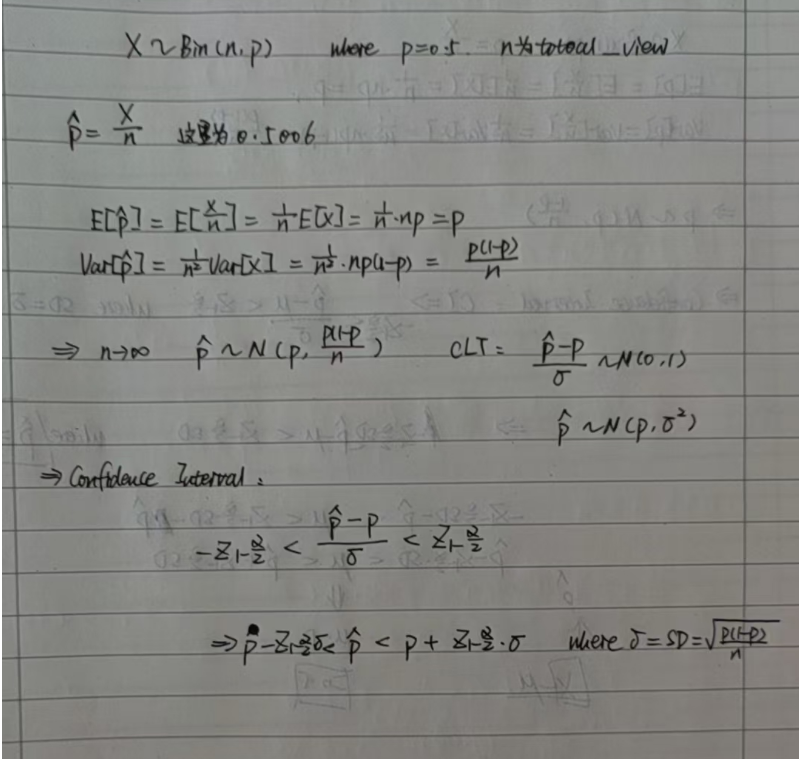|

那么只有当我们的p_hat 是落在计算出来的CI内的时候，实验才是合理的

先计算p_hat值

In [20]:
control_uv = control_data['Pageviews'].sum()
treatment_uv = treatment_data['Pageviews'].sum()
p = 0.5
p_hat = control_uv/totoal_view
print('Value of p hat ：{}'.format(p_hat))

Value of p hat ：0.5006396668806133


然后计算Confidence interval

In [21]:
sd = np.sqrt( p*(1-p)/totoal_view )
alpha = 0.05
ME = get_z_score(1-alpha/2) * sd
CI_low = p - ME
CI_high = p + ME
CI = [CI_low,CI_high]
CI

[0.4988204138245942, 0.5011795861754058]

In [22]:
(p_hat<CI_high) & (p_hat > CI_low)

True

综上：我们计算出来的p_hat是落在置信区间内的，说明2个组的样本量之间是没有显著差异的

### 6.2.2 对点击量Clicks的合理性检查

同样地，我们分析Clicks，对于每一个Clicks，它被分配到control组和treatment组的概率应该是相同的\
所有分配到control组的Clicks的数量X 也是服从二项分布的\
公式和UV的合理性检验相同

In [27]:
Clicks_control = control_data['Clicks'].sum()
Clicks_treatment = treatment_data['Clicks'].sum()
Clicks_total = Clicks_control+Clicks_treatment
p = 0.5
p_hat = Clicks_control/Clicks_total
sd = np.sqrt(p*(1-p)/Clicks_total)
ME = get_z_score(1-alpha/2) * sd
CI_low = p-ME
CI_high = p+ME
CI = [CI_low,CI_high]
print(p_hat)
print(CI)

0.5004673474066628
[0.4958845713471463, 0.5041154286528536]


In [28]:
CI_low < p_hat < CI_high

True

综上：我们计算出来的关于Clicks的p_hat是落在置信区间内的，说明被分配到2个组中的点击量是没有显著差异的

### 6.2.3 对CTP的合理性检查

对于CTP的合理性检查和前面6.2.1和6.2.2是不同的\
对于UV和Clicks数量的检查，是检查分流随机性\
而对于CTP的检查，是检查指标差异

首先明确在这个案例中CTP的计算公式\
CTP = Clicks/PageView


我们期望的是，点击率CTP在control组和treatment组是无差异的\
即CTP_control - CTP_teatment = 0

步骤：
1. 合并比例（CTP）：p_pool = （Xcontrol+Xtreatment）/ （Ncontrol + Ntreatment）
2. 合并标准误 : SD_pool = np.sqrt( p_pool(1-p_pool)* (1/Ncontrol + 1/Ntreatment) )
3. 置信区间： CI = [d - Z * Sd_pool, d + Z * Sd_pool]

In [62]:
p_pool = Clicks_total/totoal_view
p_control = Clicks_control/control_uv
p_treatment = Clicks_treatment/treatment_uv
d = p_control - p_treatment
sd_pool = np.sqrt( p_pool*(1-p_pool) * (1/control_uv + 1/treatment_uv) )
ME = get_z_score(1-alpha/2) * sd_pool
CI_low = d-ME
CI_high = d+ME
CI=[CI_low,CI_high]
CI

[-0.0013281236286900111, 0.001263187151795125]

In [63]:
CI_low < d < CI_high

True

综上：2个组CTP的差距落在了置信区间内，说明两个组在CTP上的差异是不显著的，合理性检验通过！

## 6.3 策略指标检验

在6.2中我们已经对control variables做了合理性检查。\
发现我们希望不变的control variables确实在对照组control和实验组treatment之间是没有显著性差异的\
说明实验的设计和数据的分配是没有问题的

于是在6.3中我们要开始策略指标的检验\
即对evaluation metrics在2组之间的差异做假设检验，如果差异是显著的，并且是正显著，则说明我们的实验是具有价值的

与6.2不同的是，在6.2中我们希望指标没有显著性差异，而在6.3中我们希望指标具有显著性差异

### 6.3.1 课程注册转化率 GConversion

我们浏览一下control-data的数据，会发现从index=23，即24天开始，所有的enrollemnts和payments的数据都是NA\
而我们的GC = enrollments/Clicks\
所以对于数据集control_data，只有前23行是有效数据（在5.时间周期计算中我们得到数据收集的最小周期应该为21天，所以这里是合理的）

In [51]:
control_data

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7723,687,134.0,70.0
1,"Sun, Oct 12",9102,779,147.0,70.0
2,"Mon, Oct 13",10511,909,167.0,95.0
3,"Tue, Oct 14",9871,836,156.0,105.0
4,"Wed, Oct 15",10014,837,163.0,64.0
5,"Thu, Oct 16",9670,823,138.0,82.0
6,"Fri, Oct 17",9008,748,146.0,76.0
7,"Sat, Oct 18",7434,632,110.0,70.0
8,"Sun, Oct 19",8459,691,131.0,60.0
9,"Mon, Oct 20",10667,861,165.0,97.0


In [54]:
control_data = control_data[control_data['Enrollments'].notnull()]
control_data

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7723,687,134.0,70.0
1,"Sun, Oct 12",9102,779,147.0,70.0
2,"Mon, Oct 13",10511,909,167.0,95.0
3,"Tue, Oct 14",9871,836,156.0,105.0
4,"Wed, Oct 15",10014,837,163.0,64.0
5,"Thu, Oct 16",9670,823,138.0,82.0
6,"Fri, Oct 17",9008,748,146.0,76.0
7,"Sat, Oct 18",7434,632,110.0,70.0
8,"Sun, Oct 19",8459,691,131.0,60.0
9,"Mon, Oct 20",10667,861,165.0,97.0


In [55]:
treatment_data = treatment_data[treatment_data['Enrollments'].notnull()]
treatment_data

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7716,686,105.0,34.0
1,"Sun, Oct 12",9288,785,116.0,91.0
2,"Mon, Oct 13",10480,884,145.0,79.0
3,"Tue, Oct 14",9867,827,138.0,92.0
4,"Wed, Oct 15",9793,832,140.0,94.0
5,"Thu, Oct 16",9500,788,129.0,61.0
6,"Fri, Oct 17",9088,780,127.0,44.0
7,"Sat, Oct 18",7664,652,94.0,62.0
8,"Sun, Oct 19",8434,697,120.0,77.0
9,"Mon, Oct 20",10496,860,153.0,98.0


In [67]:
enrollment_control = control_data['Enrollments'].sum()
enrollment_treatment = treatment_data['Enrollments'].sum()

Clicks_control = control_data['Clicks'].sum()
Clicks_treatment = treatment_data['Clicks'].sum()

GC_control = enrollment_control/Clicks_control
GC_treatment = enrollment_treatment/Clicks_treatment
GC_pooled = (enrollment_control + enrollment_treatment) / (Clicks_control + Clicks_treatment)

GC_pooled_sd = np.sqrt( GC_pooled* (1-GC_pooled) * (1/Clicks_control + 1/Clicks_treatment)) 
GC_pooled_ME = get_z_score(1-alpha/2) * GC_pooled_sd
GC_diff = GC_treatment - GC_control
CI_low = GC_diff - GC_pooled_ME
CI_high = GC_diff + GC_pooled_ME
CI = [CI_low,CI_high]
print(CI)
print(GC_diff)

[-0.02912320088750467, -0.011986548273218463]
-0.020554874580361565


结果：
1. 如果置信区间包含0，则代表差异不显著，而我们计算出来的置信区间是不包含0的，代表差异显著
2. 并且我们要求最小的dmin = 0.01,而这里的变化为-0.0206，所以我们认为在业务上也是显著的
3. 这里为什么要使用合并方差而不是单独计算control组和treatment组的方差：
   因为我们的GC_diff 非常小，而一般当diff>0.1，合并的方法会低估方差，影响实验结果
4. 在网页浏览量和点击量差异不显著的情况下，treatment组对于control组，来注册课程转化率上减少了-2.06%
   这说明实验策略有效的减少了课程注册用户的数量，弹窗设计有效地阻止了一部分用户登记课程，可以减轻授课老师的负担

除了计算置信区间，看0是否落在置信区间内来判断差异显著性外，还可以通过计算Z统计量来判断\
如果Z的绝对值大于Z（1-alpha/2）的值，则代表差异是显著的

Z = diff - (p1-p2) / SE

In [72]:
diff = GC_treatment - GC_control
# p1-p1假设 = 0 H0：P1-P2 = 0

SE = np.sqrt( GC_pooled * (1 - GC_pooled) * (1/Clicks_control +1/Clicks_treatment))
Z = diff/SE 
Z

-4.701830023753982

### 6.3.2 付费转化率NConversion

In [75]:
payment_control = control_data['Payments'].sum()
payment_treatment = treatment_data['Payments'].sum()

NC_control = payment_control/Clicks_control
NC_treatment = payment_treatment/Clicks_treatment

NC_diff = NC_treatment - NC_control
NC_diff

-0.0048737226745441675

差异等于 -0.004，非常小，我们可以用合并方差计算CI

In [77]:
NC_pooled = (payment_control +payment_treatment)/ (Clicks_control+Clicks_treatment)
NC_pooled_sd = np.sqrt( NC_pooled * (1-NC_pooled) * (1/Clicks_control +1/Clicks_treatment))
NC_pooled_me = get_z_score(1-alpha/2) * NC_pooled_sd
CI_low = NC_diff - NC_pooled_me
CI_high = NC_diff + NC_pooled_me
CI= [CI_low,CI_high]
print(CI)
print(NC_diff)

[-0.011604500677993734, 0.0018570553289053993]
-0.0048737226745441675


结论： 置信区间包含0，说明2组之间NC的差异是不显著的，NC在样本中2组的差异非常小，小于0.0075了\
       所以我们认为，2组之间的NC的差异在统计意义上是不显著的，并且在实际意义上也是不显著的

## 6.4 结论

对于我们的control组和treatment组\
虽然在分流随机性上：浏览量UV、点击量Clicks 是没有显著差异的\
并且在CTP上，2个组的指标也是没有显著性差异的\
这说明我们的2个组是样本分配是完全随机的并且具有意义的

但是在对于target指标的假设检验中\
我们发现GC是有显著性差异的，但是NC是不具备显著性差异的\
所以我们可以认为虽然课程注册转化率下降可以减轻授课老师的负担，没有并没有完全转化成学生体验的整体提升\
并且付费转化率的变化是不显著的，也未达到业务的最小关注阈值

所以，鉴于案例中业务要求是合理提升收入，我们建议不执行新的策略功能